# Coursework 2 for Cardiac MR Image Segmentation (2020-2021)

The aim of this work is to create a neural network that segments cardiac MR images. The dataset is comprised of 200 96x96 greyscale cardiac MR images (CMRI) along the short axis. The goal is to segment them into four different categories: myocardium, left ventricle, right ventricle, and background. The data has been pulled from the Automated Caridiac Diagnosis Challenge (ACDC) (O. Bernard, A. Lalande, C. Zotti, F. Cervenansky, 2018). Below is an example of a CMRI (left) and the segmentation (called mask) (right).
![alt text](sample_dataset.png "Example of image and true segmentation")

CMRI allows for a non-invasive examination of the heart. Appliying image segmentation allows for calculation of important quantitative measures such as right and left ventricle volume, myocardial mass, and ejection fraction (Chen, Chen et al., 2020).

This is the ideal problem for a convolutional neural network - indeed as technology and deep learning have developed, the area of medical imagery has benefited greatly. Applying a CNN to pixel-wise classification allows for a much faster and less error-prone method of segmentation.

The dataset has been split into the following three subsets: 50% for training, 10% for validation, and the remaining 40% for testing. The goal of this work is to implement a known segmentation architecture to this dataset then perform hyper-parameter optimisation to maximise the dice score on the test set. The dice score between two generic masks A, B is defined as:
<img src="https://latex.codecogs.com/gif.latex?dice(A,&space;B)&space;=&space;\frac{2|A&space;\cap&space;B|}{|A|&plus;|B|}" title="dice(A, B) = \frac{2|A \cap B|}{|A|+|B|}" />
The dice score ranges between 0 and 1 with 0 being completely wrong and 1 being a perfect match. Since there are 4 classes to be segmented then even if the theoretical minimum is 0, by just classiying each pixel at random will achieve a dice score of 0.25 (that is if each class occurs with equal frequency).

Below we define some two plotting functions: one that plots the image with the ground truth mask and another that plots the image with the ground truth mask and the predicted mask.

In [1]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')
    
#Additional function that plots the predicted segmentation along with the image and the ground truth
def show_image_mask_pred(img, mask, pred, cmap='gray'):
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap=cmap) #CMRI
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap=cmap) #ground truth mask
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap=cmap) # predicted mask
    plt.axis('off')
    plt.show()

Next, we define two classes of data loaders to store the training, validating, and test data in memory. Note that the validation data loader will be an instance of the `TrainDataset` class.

In [2]:
import torch
import torch.utils.data as data
import cv2
import os
from glob import glob
import numpy as np

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            
    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


In [3]:
import torch
import torch.utils.data as data
import cv2
import os
from glob import glob
import numpy as np

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


# Implementation
Now we define the network architecture. We opted to use the SegNet architecture (Badrinarayanan, Kendall and Cipolla, 2015) which is an encoder-decoder model for image segmentation. The idea is that the model applies a sequence of increasingly large number of convolutional filters and max-pooling layers to map the image to a low dimensional space (but with a large number of channels) and then to reverse the process by up-sampling and convolutional layers to return the image back to the same dimensionality of the input. Below is the architecture of SegNet taken from their paper.

![alt text](segnet_archi.png "Architecture of SegNet")

The first half of the network is the encoder and is topologically identical to the first 13 convolutional layers of the VGG16 architecture. Indeed, in the paper the authors apply transfer learning and initialise the encoder weights with the VGG16 weights. Then after the encoder there are 13 decoder layers each one coresponding to an encoder layer. At the end, instead of having a fully connected layer (such as the one found in VGG16), SegNet opts to map straight from the high-resolution feature map straight to a pixel-wise softmax classification. Each convolutional layer uses a 3x3 kernel with 1 padding. The number of filters can be seen in the code below. The other notable feature of SegNet is the connection between each max-pooling layer and its corresponding up-sampling. When the down-pooling occurs, the model stores the index of where the maximum value in the max-pooling occurs and uses those indices to up-sample. Below we define the model in `CNNSEG()`.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNSEG(nn.Module):
    def __init__(self):
        super(CNNSEG, self).__init__()
        # fill in the constructor for your model here
        #Encoder layers
        self.encoder_00 = nn.Sequential(*[nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3,padding=1),
                                                nn.BatchNorm2d(64)])
        
        self.encoder_01 = nn.Sequential(*[nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1),
                                                nn.BatchNorm2d(64)])
        
        self.encoder_10 = nn.Sequential(*[nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
                                                nn.BatchNorm2d(128)])
        
        self.encoder_11 = nn.Sequential(*[nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),
                                                nn.BatchNorm2d(128)])
        
        self.encoder_20 = nn.Sequential(*[nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1),
                                                nn.BatchNorm2d(256)])
        
        self.encoder_21 = nn.Sequential(*[nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1),
                                                nn.BatchNorm2d(256)])
        
        self.encoder_22 = nn.Sequential(*[nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1),
                                                nn.BatchNorm2d(256)])
        
        self.encoder_30 = nn.Sequential(*[nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1),
                                                nn.BatchNorm2d(512)])
        
        self.encoder_31 = nn.Sequential(*[nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1),
                                                nn.BatchNorm2d(512)])
        
        self.encoder_32 = nn.Sequential(*[nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1),
                                                nn.BatchNorm2d(512)])
        
        self.encoder_40 = nn.Sequential(*[nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1),
                                                nn.BatchNorm2d(512)])
        
        self.encoder_41 = nn.Sequential(*[nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1),
                                                nn.BatchNorm2d(512)])
        
        self.encoder_42 = nn.Sequential(*[nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1),
                                                nn.BatchNorm2d(512)])
        
        #Decoder layers
        
        
        self.decoder_42 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=512,out_channels=512,
                                                             kernel_size=3,padding=1),
                                                nn.BatchNorm2d(512)])
        
        self.decoder_41 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=512,out_channels=512,
                                                             kernel_size=3,padding=1),
                                                nn.BatchNorm2d(512)])
        
        self.decoder_40 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=512,out_channels=512,
                                                             kernel_size=3,padding=1),
                                                nn.BatchNorm2d(512)])
        
        self.decoder_32 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=512,out_channels=512,
                                                             kernel_size=3,padding=1),
                                                nn.BatchNorm2d(512)])
        
        self.decoder_31 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=512,out_channels=512,
                                                             kernel_size=3,padding=1),
                                                nn.BatchNorm2d(512)])
        
        self.decoder_30 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=512,out_channels=256,
                                                             kernel_size=3,padding=1),
                                                nn.BatchNorm2d(256)])
        
        self.decoder_22 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=256,out_channels=256,
                                                             kernel_size=3,padding=1),
                                                nn.BatchNorm2d(256)])
        
        self.decoder_21 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=256,out_channels=256,
                                                             kernel_size=3,padding=1),
                                                nn.BatchNorm2d(256)])
        
        self.decoder_20 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=256,out_channels=128,
                                                             kernel_size=3,padding=1),
                                                nn.BatchNorm2d(128)])
        
        self.decoder_11 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=128,out_channels=128,
                                                             kernel_size=3,padding=1),
                                                nn.BatchNorm2d(128)])
        
        self.decoder_10 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=128,out_channels=64,
                                                             kernel_size=3,padding=1),
                                                nn.BatchNorm2d(64)])
        
        self.decoder_01 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=64,out_channels=64,
                                                             kernel_size=3,padding=1),
                                                nn.BatchNorm2d(64)])
        
        self.decoder_00 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=64,out_channels=4,
                                                             kernel_size=3,padding=1)])
        
        
    def forward(self, x):
        # Encoder

        # Encoder Stage - 1
        dim_0 = x.size()
        x_00 = F.relu(self.encoder_00(x))
        x_01 = F.relu(self.encoder_01(x_00))
        x_0, indices_0 = F.max_pool2d(x_01, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 2
        dim_1 = x_0.size()
        x_10 = F.relu(self.encoder_10(x_0))
        x_11 = F.relu(self.encoder_11(x_10))
        x_1, indices_1 = F.max_pool2d(x_11, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 3
        dim_2 = x_1.size()
        x_20 = F.relu(self.encoder_20(x_1))
        x_21 = F.relu(self.encoder_21(x_20))
        x_22 = F.relu(self.encoder_22(x_21))
        x_2, indices_2 = F.max_pool2d(x_22, kernel_size=2, stride=2, return_indices=True)
        
        # Encoder Stage - 4
        dim_3 = x_2.size()
        x_30 = F.relu(self.encoder_30(x_2))
        x_31 = F.relu(self.encoder_31(x_30))
        x_32 = F.relu(self.encoder_32(x_31))
        x_3, indices_3 = F.max_pool2d(x_32, kernel_size=2, stride=2, return_indices=True)
        
        # Encoder Stage - 5
        dim_4 = x_3.size()
        x_40 = F.relu(self.encoder_40(x_3))
        x_41 = F.relu(self.encoder_41(x_40))
        x_42 = F.relu(self.encoder_42(x_41))
        x_4, indices_4 = F.max_pool2d(x_42, kernel_size=2, stride=2, return_indices=True)

        # Decoder

        dim_d = x_4.size()

        # Decoder Stage - 5
        x_4d = F.max_unpool2d(x_4, indices_4, kernel_size=2, stride=2, output_size=dim_4)
        x_42d = F.relu(self.decoder_42(x_4d))
        x_41d = F.relu(self.decoder_41(x_42d))
        x_40d = F.relu(self.decoder_40(x_41d))
        
        # Decoder Stage - 4
        x_3d = F.max_unpool2d(x_3, indices_3, kernel_size=2, stride=2, output_size=dim_3)
        x_32d = F.relu(self.decoder_32(x_3d))
        x_31d = F.relu(self.decoder_31(x_32d))
        x_30d = F.relu(self.decoder_30(x_31d))
        
        # Decoder Stage - 3
        x_2d = F.max_unpool2d(x_30d, indices_2, kernel_size=2, stride=2, output_size=dim_2)
        x_22d = F.relu(self.decoder_22(x_2d))
        x_21d = F.relu(self.decoder_21(x_22d))
        x_20d = F.relu(self.decoder_20(x_21d))

        # Decoder Stage - 2
        x_1d = F.max_unpool2d(x_20d, indices_1, kernel_size=2, stride=2, output_size=dim_1)
        x_11d = F.relu(self.decoder_11(x_1d))
        x_10d = F.relu(self.decoder_10(x_11d))

        # Decoder Stage - 1
        x_0d = F.max_unpool2d(x_10d, indices_0, kernel_size=2, stride=2, output_size=dim_0)
        x_01d = F.relu(self.decoder_01(x_0d))
        x_00d = self.decoder_00(x_01d)

        x_softmax = F.softmax(x_00d, dim=1)

        return x_softmax

model = CNNSEG()

We can see the summary of the model including the shape of the tensor at each step and the number of trainable parameters. Due to the fact that the network is fully convolutional and the use of max-pooling indices in up-sampling allows the model to have relatively less trainable parameters. 

In [5]:
from torchsummary import summary
summary(model, (1, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]             640
       BatchNorm2d-2           [-1, 64, 96, 96]             128
            Conv2d-3           [-1, 64, 96, 96]          36,928
       BatchNorm2d-4           [-1, 64, 96, 96]             128
            Conv2d-5          [-1, 128, 48, 48]          73,856
       BatchNorm2d-6          [-1, 128, 48, 48]             256
            Conv2d-7          [-1, 128, 48, 48]         147,584
       BatchNorm2d-8          [-1, 128, 48, 48]             256
            Conv2d-9          [-1, 256, 24, 24]         295,168
      BatchNorm2d-10          [-1, 256, 24, 24]             512
           Conv2d-11          [-1, 256, 24, 24]         590,080
      BatchNorm2d-12          [-1, 256, 24, 24]             512
           Conv2d-13          [-1, 256, 24, 24]         590,080
      BatchNorm2d-14          [-1, 256,

In accordance with the SegNet paper, the loss function was chosen to be categorical cross-entropy. This is the natural choice for classification problems and is perfect for our case as we are performing pixel-wise classification. Unlike in the paper, we opted to use the Adam optimiser as it is currently one of the most popular optimisers. We allow pytorch to use GPU acceleration if it is available. Lastly, we initialise the learning rate at 0.001 as well as training, validation loss and dice score lists to store the training history.

In [6]:
#Set the learning rate
LEARNING_RATE = 0.001

#Initialise cross entropy loss and adam optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                                     lr=LEARNING_RATE)

#if gpu is available then it sends it to gpu else it uses cpu 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if torch.cuda.is_available():
    model.cuda()

#Initialise list to store loss over training
train_loss = list()
val_loss = list()
dice_score = list()

Below we define some helper functions:
- `categorical_dice` which computes the categorical dice between two masks for a specific class. Small correction has been made to the code provided.
- `forward` which preprocesses the image tensor by making it the right dimension and dividing each element component-wise by 255 to make the tensor lie inside the hypercube (granted of very high dimension). The gradients get set to zero in the optimiser and we push the mini-batch forwards through the network and return the softmax output of the model as a tensor of shape Bx4x96x96 where B is the batch size, 4 corresponds to the four categories and 96x96 is the image pixels.

In [7]:
#categorical dice score between mask1 and mask2 along label_class
def categorical_dice(mask1, mask2, label_class=1):
    mask1_pos = (mask1 == label_class).numpy()
    mask2_pos = (mask2 == label_class).numpy()
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

#Packages proprocessing and forward pass
def forward(img):
    #scales image so that each pixel lies between 0 and 1
    img_scale = img/255.
    
    #reshapes the tensor 
    img_scale = img_scale.unsqueeze(1)
    
    #resets optimiser 
    optimizer.zero_grad()
    
    #pushes processed image through network
    seg_soft = model(img_scale)
    
    return seg_soft

Using the `TrainDataset` class defined above as well as pytorch's `DataLoader` functionality, we create two data loaders. One for the training set and one for the validation set. Initial value of 10 for batch_size was chosen but later will be changed for experimentation.

In [8]:
from torch.utils.data import DataLoader
#create path to data
data_path = './data/train'
val_path = './data/val'
#initialise number of workers and batch size for data loaders
num_workers = 8
batch_size = 10

#load data into data loaders and put the into a dict type
train_set = TrainDataset(data_path)
val_set = TrainDataset(val_path)

training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
validating_data_loader = DataLoader(dataset=val_set, num_workers=num_workers, batch_size=80, shuffle=True)


data_loader = {'train':training_data_loader,
              'validate':validating_data_loader}

Now we define the `train()` function that is passed the data loader dictionary, optimiser and loss function as arguements and returns the train and validation loss as well as the dice score computed throughout the training. We train the model for 100 epochs and store the weights of the model that gave the lowest validation loss.

Training is done in the standard way: we unpack the data from the data loader, it is then sent to the GPU (if it is available), pushed through the `forward()` function defined above that deals with preprocessing and doing the forward pass. The function returns the softmax activation of the model which is used to then compute the loss. The loss is passed backwards through the network and the optimiser takes a step. For each training step, the batch loss is computed and stored to keep track of training. 

For the validation set, the model is set to not train. In a similar fashion, the image is passed through but once it reaches the loss stage, the loss is computed and stored without pushing it back through the network and optimising. The validation set is only used to prevent the model from over-fitting on the training data.

In [9]:
def train(data_loader, optimizer, loss_fn):
    print('Loss function ', loss_fn )
    print('optimizer ', optimizer)
    print('Mini Batch size set to ', batch_size)
    print(device)


    EPOCHS = 100
    best_val = 100

    for epochs in range(EPOCHS):
        print('-' * 10)
        print('Epoch {}/{}'.format(epochs+1, EPOCHS))

        #TRAINING
        model.train(True)

        batch_loss = 0.0

        for index_train, sample in enumerate(data_loader['train']):

            #unpack data and send it to device (GPU/CPU)
            img, mask = sample
            img, mask = img.to(device), mask.to(device)

            #preprocess and pass through network
            soft_mask = forward(img)

            #compute and push back loss
            loss = loss_fn(soft_mask, mask.long())
            loss.backward()

            #optimise on the loss
            optimizer.step()

            batch_loss += loss.item()

        train_loss.append(batch_loss / (index_train + 1))

        print("Train loss: ", train_loss[-1])

        #VALIDATING
        model.train(False)

        batch_loss = 0.0

        for index_val, sample in enumerate(data_loader['validate']):
            #unpack data and send to device
            img, mask = sample
            img, mask = img.to(device), mask.to(device)

            #preprocess and pass through network
            soft_mask = forward(img)

            #compute loss
            loss = loss_fn(soft_mask, mask.long())

            batch_loss += loss.item()

        val_loss.append(batch_loss / (index_val + 1))

        #compute and store categorical dice score
        dice_score_batch = np.mean([categorical_dice(mask, torch.argmax(soft_mask, dim=1), label_class=c) 
                                    for c in [0,1,2,3]])

        dice_score.append(dice_score_batch)

        #check if this weight results in lowest validation loss
        if val_loss[-1] < best_val:
            torch.save([model.state_dict(), val_loss[-1]], './segnet.pth')
            best_val = val_loss[-1]
            print("Found better")

        print("Validation loss: ", val_loss[-1])
        print("Dice score: ", dice_score_batch)
    return train_loss, val_loss, dice_score

Loss function  CrossEntropyLoss()
optimizer  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Mini Batch size set to  25
cpu
----------
Epoch 1/100
Train loss:  1.1907135546207428
Found better
Validation loss:  1.3220692873001099
Dice score:  0.22676952450977486
----------
Epoch 2/100
Train loss:  0.9651130139827728
Validation loss:  1.5677934885025024
Dice score:  0.11657515955943923
----------
Epoch 3/100
Train loss:  0.9022946059703827
Validation loss:  1.3890368938446045
Dice score:  0.1887524770552379
----------
Epoch 4/100
Train loss:  0.8685487508773804
Validation loss:  1.459784746170044
Dice score:  0.1515035741083483
----------
Epoch 5/100
Train loss:  0.8509644567966461
Found better
Validation loss:  1.2911052703857422
Dice score:  0.21818390794501083
----------
Epoch 6/100
Train loss:  0.8388635963201523
Validation loss:  1.3907243013381958
Dice score:  0.17630057915548336
----------
Epoch 7/100
Train los

Train loss:  0.7589363306760788
Validation loss:  0.7885631322860718
Dice score:  0.8456051578552478
----------
Epoch 65/100
Train loss:  0.7565690577030182
Found better
Validation loss:  0.7822650671005249
Dice score:  0.8739751615125346
----------
Epoch 66/100
Train loss:  0.7563050985336304
Found better
Validation loss:  0.7806515097618103
Dice score:  0.8784279491683631
----------
Epoch 67/100
Train loss:  0.7555929571390152
Validation loss:  0.7880361080169678
Dice score:  0.8537350199268952
----------
Epoch 68/100
Train loss:  0.7570546418428421
Validation loss:  0.7930583357810974
Dice score:  0.8313653018091544
----------
Epoch 69/100
Train loss:  0.7563739269971848
Validation loss:  0.7976248860359192
Dice score:  0.8108627879512242
----------
Epoch 70/100
Train loss:  0.756492093205452
Validation loss:  0.786649763584137
Dice score:  0.8570345196798982
----------
Epoch 71/100
Train loss:  0.7567161917686462
Validation loss:  0.7881408929824829
Dice score:  0.8501422191830112


Calling the train function trains the model and returns the lists outlined above.

In [ ]:
train_loss, val_loss, dice_score = train(data_loader, optimizer, loss_fn)

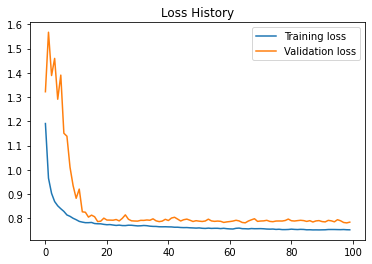

In [10]:
plt.plot(train_loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Loss History")
plt.show()


# References
Badrinarayanan, V., Kendall, A. and Cipolla, R., 2015. Segnet: A Deep Convolutional Encoder-Decoder Architecture For Image Segmentation. [online] arXiv.org. Available at: <https://arxiv.org/abs/1511.00561v3> [Accessed 14 December 2020].

O. Bernard, A. Lalande, C. Zotti, F. Cervenansky, et al.
"Deep Learning Techniques for Automatic MRI Cardiac Multi-structures Segmentation and
Diagnosis: Is the Problem Solved ?" in IEEE Transactions on Medical Imaging,
vol. 37, no. 11, pp. 2514-2525, Nov. 2018
doi: 10.1109/TMI.2018.2837502

Chen, Chen et al. “Deep Learning for Cardiac Image Segmentation: A Review.” Frontiers in cardiovascular medicine vol. 7 25. 5 Mar. 2020, doi:10.3389/fcvm.2020.00025